In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from pathlib import Path
from sklearn.decomposition import PCA 
from sklearn.linear_model import LinearRegression
import pandas as pd
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


dirPath = '/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/juiceTaskDefault/juiceTaskDefault_20231204-12-12_3_'


In [2]:
def importAndPreprocess(dirPath,activityFileName):
    import os
    import sys

    
    with np.load(os.path.join(dirPath,activityFileName),allow_pickle=True) as f:
        x = f['x']
        trial_params = f['trial_params']
        model_output = f['model_output']
        model_state = f['model_state']
        mask = f.get('mask', None)
    
    if mask is None:
        temp = np.mean(model_output[:,300:,:],1)
    else: 
        temp = np.mean(mask * model_output,1)
    choiceLR = temp[:,1]>temp[:,0]
    choiceLR = choiceLR*2-1 # pos right high, neg left high
    
    choiceFrame = [trial_params[i]['choiceFrame'] for i in range(len(trial_params))]
    
    
    locAB = [(1 if trial_params[i]['locAB']=='AB' or trial_params[i]['locAB']=='12' else -1) for i in range(len(trial_params))]
    loc12 = locAB
    seqAB = [(1 if trial_params[i]['seqAB']=='AB' else -1) for i in range(len(trial_params))]
    
    choiceAB = np.array([(choiceLR[i] * locAB[i] if choiceFrame[i]=='juice' else choiceLR[i] * locAB[i] * seqAB[i]) for i in range(len(trial_params)) ])  # pos B neg A
    choice12 = np.array([(choiceAB[i] * seqAB[i] if choiceFrame[i]=='juice' else choiceLR[i] * locAB[i]) for i in range(len(trial_params)) ])  # pos 2 neg 1
    choiceAB = np.array(['B' if choiceAB[i]>0 else 'A' for i in range(len(trial_params))])
    choice12 = np.array(['2' if choice12[i]>0 else '1' for i in range(len(trial_params))])
    
    qAs = np.array([trial_params[i]['qA'] for i in range(len(trial_params))])
    qBs = np.array([trial_params[i]['qB'] for i in range(len(trial_params))])
    seqAB = np.array([trial_params[i]['seqAB']for i in range(len(trial_params))])

    return x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB

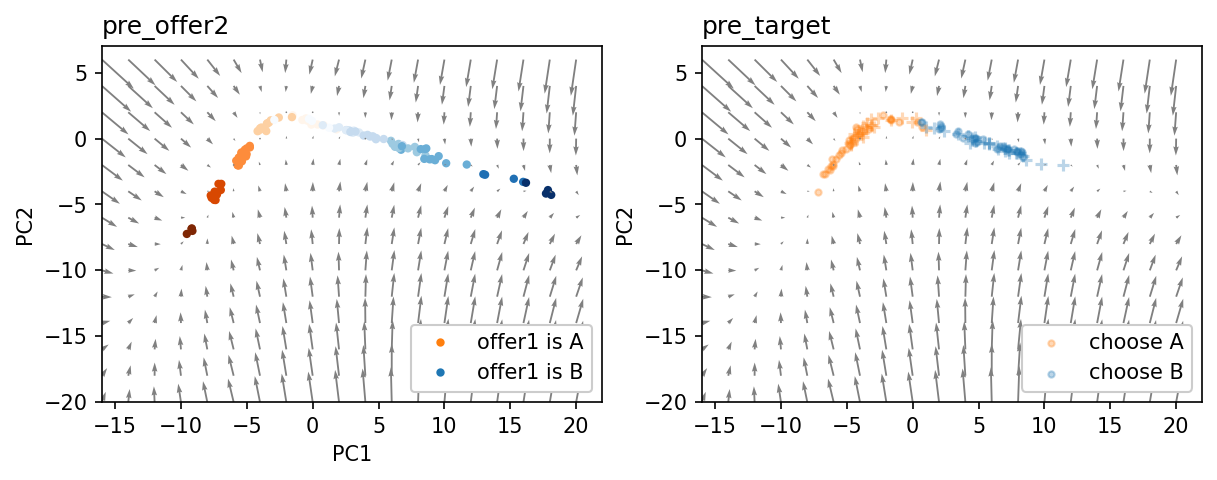

In [3]:
x,trial_params,model_state,choice12,choiceAB,choiceLR,qAs,qBs,seqAB = importAndPreprocess(dirPath,'activitityTest.npz')


K,T,N = model_state.shape

pcaObj = PCA(n_components=4)
X = model_state[:,50:250,:].reshape((K*200,N))
pcaObj.fit(X)


t1=150
t2=250
xx,yy=0,1
fig = plt.figure(figsize=(8,6),dpi=150,constrained_layout=True)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122,sharex=ax1,sharey=ax1)

xmin, xmax, ymin, ymax = -16,22,-20,7

ax = ax2
points = pcaObj.transform(np.squeeze(model_state[:,t2,:]))
ax2.scatter(points[(choiceAB=='A')&(seqAB=='AB'),xx],points[(choiceAB=='A')&(seqAB=='AB'),yy],marker='+',alpha=0.3,color='tab:orange',label='_Hidden choose A|AB')
ax2.scatter(points[(choiceAB=='A')&(seqAB=='BA'),xx],points[(choiceAB=='A')&(seqAB=='BA'),yy],marker='.',alpha=0.3,color='tab:orange',label='choose A')
ax2.scatter(points[(choiceAB=='B')&(seqAB=='AB'),xx],points[(choiceAB=='B')&(seqAB=='AB'),yy],marker='.',alpha=0.3,color='tab:blue',label='choose B')
ax2.scatter(points[(choiceAB=='B')&(seqAB=='BA'),xx],points[(choiceAB=='B')&(seqAB=='BA'),yy],marker='+',alpha=0.3,color='tab:blue',label='_Hidden choose B|BA')
# ax2.set_xlabel('PC%d'%(xx+1))
ax2.set_ylabel('PC%d'%(yy+1))
ax.set_aspect('equal','box')
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
# ax.text(xmin+(xmax-xmin)*0.01,ymin+(ymax-ymin)*0.01,"t=%dms"%(t2*10))
ax.set_title('pre_target',loc='left')
ax.legend(frameon=True,loc='lower right',framealpha=1)


ax = ax1
points = pcaObj.transform(np.squeeze(model_state[:,t1,:]))
sctA = ax1.scatter(points[seqAB=='AB',xx],points[seqAB=='AB',yy],marker='.',
        c = qAs[seqAB=='AB'],cmap='Oranges')
proxyA, = ax.plot([],[],marker='.',color='tab:orange',linestyle='None',label='offer1 is A')
sctB = ax1.scatter(points[seqAB=='BA',xx],points[seqAB=='BA',yy],marker='.',label='offer1 is B',
        c = qBs[seqAB=='BA'],cmap='Blues')
proxyB, = ax.plot([],[],marker='.',color='tab:blue',linestyle='None',label='offer1 is B')
ax.set_xlabel('PC%d'%(xx+1))
ax.set_ylabel('PC%d'%(yy+1))
ax.set_aspect('equal','box')
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
# ax.text(xmin+(xmax-xmin)*0.01,ymin+(ymax-ymin)*0.01,"t=%dms"%(t1*10))
ax.set_title('pre_offer2',loc='left')
hh=ax.legend(handles=[proxyA,proxyB],frameon=True,loc='lower right',framealpha=1)


# fig.savefig(os.path.join(dirPath,f'representation_dim{xx+1}dim{yy+1}.pdf'))

# connectivity - vector field
with np.load(os.path.join(dirPath,'weightFinal.npz'),allow_pickle=True) as f:
    weights = f
    W_rec = weights['W_rec']
    W_in = weights['W_in']
    b_rec = weights['b_rec']
relu = lambda x: x*(x>0)
tau=100
def F(x,x_in=np.zeros(W_in.shape[1])):
    x = x.T
    M = x.shape[1]
    leaky = -x
    recurrent = np.matmul(W_rec,relu(x)) + np.tile(b_rec.reshape(-1,1),(1,M))
    input = np.matmul(W_in,(x_in))
    input = np.tile(input.reshape(-1,1),(1,M))
    
    der= (leaky+recurrent+input)/tau
    return der.T


UU = pcaObj.components_[0:2,:]
PP = UU.T @ UU

v1 = pcaObj.components_[0,:]
v2 = pcaObj.components_[1,:]
v0 = pcaObj.mean_

N_grid = 24
xv,yv = np.meshgrid(np.arange(xmin,xmax,2),np.arange(ymin,ymax,2))
state_grid = np.outer(xv.reshape(-1),v1) + np.outer(yv.reshape(-1),v2) +v0

vec_grid_noInput = F(state_grid,np.array([0,0,0,0,0,0,0,0,1]))
vec_grid_noInput_project = vec_grid_noInput @ UU.T
vec_grid_noInput_project = vec_grid_noInput_project.reshape((xv.shape[0],xv.shape[1],2))

xpc = (v1@ UU.T)[0] * xv + (v2@ UU.T)[0] * yv
ypc = (v1@ UU.T)[1] * xv + (v2@ UU.T)[1] * yv
ax1.quiver(xpc,ypc,vec_grid_noInput_project[:,:,0],vec_grid_noInput_project[:,:,1],label='projected derivatives',color='grey')
ax2.quiver(xpc,ypc,vec_grid_noInput_project[:,:,0],vec_grid_noInput_project[:,:,1],label='projected derivatives',color='grey')

fig.savefig('/gpfsnyu/scratch/jtg374/psychrnn/Figure/Fig3/Fig3AB.pdf')

In [4]:
#TODO: Angle
def offer1Encoding(Y,trial_params):
    K,N = Y.shape
    seqAB = np.array([trial_params[i]['seqAB']for i in range(K)])
    qAs = np.array([trial_params[i]['qA']for i in range(K)])
    qBs = np.array([trial_params[i]['qB']for i in range(K)])
    modelA = LinearRegression().fit(qAs[seqAB=='AB'].reshape(-1,1),Y[seqAB=='AB',:])
    modelB = LinearRegression().fit(qBs[seqAB=='BA'].reshape(-1,1),Y[seqAB=='BA',:])
    
    return modelA,modelB


def angle_between_axis(v1,v2):
    inner_product = np.dot(v1,v2)
    cosDist = inner_product/(np.linalg.norm(v1)*np.linalg.norm(v2))
    return np.arccos(cosDist)

modelADelay,modelBDelay = offer1Encoding(
    Y=model_state[:,150,:],
    trial_params=trial_params)

axis_full_A,axis_full_B = modelADelay.coef_.flatten(),modelBDelay.coef_.flatten()
axis_2d_A,axis_2d_B = axis_full_A@UU.T,axis_full_B@UU.T

angle_full = angle_between_axis(axis_full_A,axis_full_B) *180/np.pi
angle_2d = angle_between_axis(axis_2d_A,axis_2d_B) *180/np.pi

print(angle_full,angle_2d)


120.11011235832993 120.15385506557642


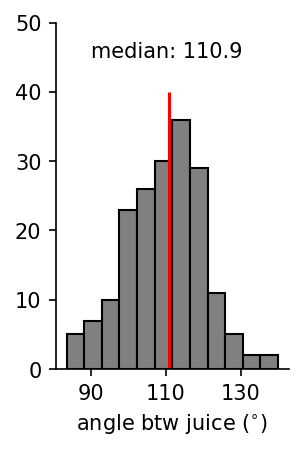

In [14]:

corrcoef_juice = np.load('./Figure/Fig3/corrcoef_juice.npy')
csv_juice = pd.read_csv('/gpfsnyu/scratch/jtg374/psychrnn/savedForHPC/0-analysis/activityAnalysis.juiceTaskDefault.csv',
    header=1)    


fig,ax = plt.subplots(dpi=150,figsize=(2,3))
plt.hist(csv_juice['angle_AB_encoding_tDelay']*180/np.pi,bins=12,color='grey',edgecolor='k')
median = np.median(csv_juice['angle_AB_encoding_tDelay']*180/np.pi)
ax.vlines(median,0,40,color='r')
ax.text(90,45,f'median: {median:.1f}')
ax.set_xlabel('angle btw juice ($^{\circ}$)')
ax.set_xticks(np.arange(90,150,20))
ax.set_ylim(0,50)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('/gpfsnyu/scratch/jtg374/psychrnn/Figure/newFig4C.pdf')

# fig,ax = plt.subplots(dpi=150,figsize=(4,3))
# sns.histplot(corrcoef_juice,ax=ax)
# median = np.median(corrcoef_juice)
# ax.vlines(median,0,37,color='k')
# ax.text(0.67,35,f'median: {median:.1f}')
# ax.set_xlabel('slope-auc correlation')
# fig.savefig('/gpfsnyu/scratch/jtg374/psychrnn/Figure/Fig3/Fig3D.pdf')

